### DATA CLEANING PIPELINE

 Import libraries, data, and clean datasets

In [1]:
#@title

# Imports and set up

import requests
import csv
from google.colab import drive
import pandas as pd
from pandas import DataFrame, merge

# Adding google drive documents
drive.mount('/content/gdrive')


# Loading datasets
# Stats from NBA Games from 2015
#  https://drive.google.com/uc?export=do...
df_games = pd.read_csv('/content/gdrive/Shareddrives/ML_Final_Project/Stats/detail_nba_games.csv')
# Elo Stats from NBA games since 1947
df_elo = pd.read_csv('/content/gdrive/Shareddrives/ML_Final_Project/Stats/2014_nba_elo.csv')

# For viewing purposes
pd.set_option('display.max_columns', None)



# Clean up a little
df = df_games

df['date'] =pd.to_datetime(df.date)
df = df.rename(columns = {'team1' : 'home_team', 'team2':'away_team'})

del df['mp.1']
del df['mp_opp.1']
del df['index_opp']
del df['Unnamed: 0'] ## what is Unnamed: O

df = df.sort_values('date')
df = df.reset_index(drop=True)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Get result of next game. Then, clean up

In [2]:
# Setup

# Get the result from the next game

def next_game(team):
  team["next_game"] = team["won"].shift(-1)
  return team
df = df.groupby("team",group_keys=False).apply(next_game)


# denote the last game of the season with the number 2
df["next_game"][pd.isnull(df["next_game"])] = 2 
df["next_game"] = df["next_game"].astype(int, errors="ignore")


# Clean 

# Remove all columns with null values
nulls = pd.isnull(df)
nulls = nulls.sum()
nulls = nulls[nulls>0]
valid_cols = df.columns[~df.columns.isin(nulls.index)]
df = df[valid_cols].copy()


# ridge regression works best with scaled data
dont_scale = ["season","season_y","date","won","next_game",
              "team","team_opp","away_team","home_team"]
scale_cols = df.columns[~df.columns.isin(dont_scale)]



<ipython-input-2-556a0a25096f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["next_game"][pd.isnull(df["next_game"])] = 2


In [3]:
df

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,team,total,home,mp_opp,fg_opp,fga_opp,fg%_opp,3p_opp,3pa_opp,3p%_opp,ft_opp,fta_opp,ft%_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,tov_opp,pf_opp,pts_opp,ts%_opp,efg%_opp,3par_opp,ftr_opp,orb%_opp,drb%_opp,trb%_opp,ast%_opp,stl%_opp,blk%_opp,tov%_opp,usg%_opp,ortg_opp,drtg_opp,fg_max_opp,fga_max_opp,fg%_max_opp,3p_max_opp,3pa_max_opp,3p%_max_opp,ft_max_opp,fta_max_opp,ft%_max_opp,orb_max_opp,drb_max_opp,trb_max_opp,ast_max_opp,stl_max_opp,blk_max_opp,tov_max_opp,pf_max_opp,pts_max_opp,+/-_max_opp,ts%_max_opp,efg%_max_opp,3par_max_opp,ftr_max_opp,orb%_max_opp,drb%_max_opp,trb%_max_opp,ast%_max_opp,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,next_game
0,240,37,82,0.451,8,27,0.296,12,15,0.800,7,33,40,22,9,4,15,25,94,0.530,0.500,0.329,0.183,16.3,58.9,40.4,59.5,9.4,6.0,14.5,100,98.6,111.2,8,16,1.000,2,6,1.000,3,4,1.0,3,7,8,4,4,3,5,4,20,10,1.330,1.500,1.000,2.000,20.5,28.8,17.9,34.6,10.6,7.1,57.1,33.8,258,121,ATL,94,1,240,37,96,0.385,12,29,0.414,20,26,0.769,23,36,59,23,5,3,15,15,106,0.493,0.448,0.302,0.271,41.1,83.7,59.6,62.2,5.2,5.5,12.3,100,111.2,98.6,7,19,0.600,4,7,0.571,6,10,1.0,8,11,19,5,2,2,3,4,21,26,0.685,0.643,0.833,0.625,18.5,41.2,24.8,35.6,3.2,4.7,33.3,23.6,132,104,DET,106,0,2016,2015-10-27,False,1
1,240,37,96,0.385,12,29,0.414,20,26,0.769,23,36,59,23,5,3,15,15,106,0.493,0.448,0.302,0.271,41.1,83.7,59.6,62.2,5.2,5.5,12.3,100,111.2,98.6,7,19,0.600,4,7,0.571,6,10,1.0,8,11,19,5,2,2,3,4,21,26,0.685,0.643,0.833,0.625,18.5,41.2,24.8,35.6,3.2,4.7,33.3,23.6,132,104,DET,106,0,240,37,82,0.451,8,27,0.296,12,15,0.800,7,33,40,22,9,4,15,25,94,0.530,0.500,0.329,0.183,16.3,58.9,40.4,59.5,9.4,6.0,14.5,100,98.6,111.2,8,16,1.000,2,6,1.000,3,4,1.0,3,7,8,4,4,3,5,4,20,10,1.330,1.500,1.000,2.000,20.5,28.8,17.9,34.6,10.6,7.1,57.1,33.8,258,121,ATL,94,1,2016,2015-10-27,True,1
2,240,41,96,0.427,9,30,0.300,20,22,0.909,21,35,56,29,8,7,20,29,111,0.525,0.474,0.313,0.229,45.7,81.4,62.9,70.7,8.0,10.8,15.9,100,110.9,94.9,14,26,1.000,5,12,1.000,7,7,1.0,5,5,9,7,2,2,7,5,40,20,1.136,1.000,0.462,0.571,39.0,27.2,25.2,50.1,19.1,7.9,69.4,43.7,206,104,GSW,111,1,240,35,83,0.422,6,18,0.333,19,27,0.704,8,25,33,21,9,3,18,26,95,0.501,0.458,0.217,0.325,18.6,54.3,37.1,60.0,9.0,4.5,15.9,100,94.9,110.9,7,20,1.000,2,7,0.667,10,15,1.0,3,5,6,9,3,3,5,5,18,5,1.000,1.000,1.000,0.750,19.8,26.3,13.6,43.4,5.3,6.3,37.5,38.9,201,120,NOP,95,0,2016,2015-10-27,True,1
3,240,37,87,0.425,7,19,0.368,16,23,0.696,7,40,47,13,6,10,13,22,97,0.499,0.466,0.218,0.264,15.2,78.4,48.5,35.1,6.0,15.4,11.8,100,97.5,95.5,8,22,0.750,3,5,0.750,5,5,1.0,2,8,10,5,2,6,4,6,19,9,0.820,0.875,0.556,1.333,12.2,38.5,26.0,30.3,2.8,14.0,53.2,34.6,162,104,CHI,97,1,240,38,94,0.404,9,29,0.310,10,17,0.588,11,39,50,26,5,7,10,21,95,0.468,0.452,0.309,0.181,21.6,84.8,51.5,68.4,5.0,10.3,9.0,100,95.5,97.5,12,22,0.571,3,7,0.500,3,4,1.0,4,10,12,7,1,2,3,4,25,9,0.714,0.714,1.000,2.000,10.8,41.9,23.8,31.2,2.8,18.5,30.4,29.0,138,105,CLE,95,0,2016,2015-10-27,True,1
4,240,35,83,0.422,6,18,0.333,19,27,0.704,8,25,33,21,9,3,18,26,95,0.501,0.458,0.217,0.325,18.6,54.3,37.1,60.0,9.0,4.5,15.9,100,94.9,110.9,7,20,1.000,2,7,0.667,10,15,1.0,3,5,6,9,3,3,5,5,18,5,1.000,1.000,1.000,0.750,19.8,26.3,13.6,43.4,5.3,6.3,37.5,38.9,201,120,NOP,95,0,240,41,96,0.427,9,30,0.300,20,22,0.909,21,35,56,29,8,7,20,29,111,0.525,0.474,0.313,0.229,45.7,81.4,62.9,70.7,8.0,10.8,15.9,100,110.9,94.9,14,26,1.000,5,12,1.000,7,7,1.0,5,5,9,7,2,2,7,5,40,20,1.136,1.000,0.462,0.571,39.0,27.2,25.2,50.1,19.1,7.9,69.4,43.7,206,104,GSW,111,1,2016,2015-10-27,False,0
...,...,...,...,...,...,...,.


Add rolling stats, if next game is home, and stats on next opponent

In [4]:
df_rolling = df[list(scale_cols) + ["won","team","season"]]

# add data that averages each teams' stats from the past 10 games 
# for a given season
def rolling_averages(team):
  rolling = team.rolling(10).mean()
  return rolling

df_rolling = df_rolling.groupby(["team", "season"], 
                                group_keys=False).apply(rolling_averages)


rolling_cols = [f"{col}_10_avg" for col in df_rolling.columns]
df_rolling.columns = rolling_cols

df2 = pd.concat([df, df_rolling], axis=1) #df2

# need to eliminate nans (drop first 10 games) 
df2 = df2.dropna() #df
df2

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,team,total,home,mp_opp,fg_opp,fga_opp,fg%_opp,3p_opp,3pa_opp,3p%_opp,ft_opp,fta_opp,ft%_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,tov_opp,pf_opp,pts_opp,ts%_opp,efg%_opp,3par_opp,ftr_opp,orb%_opp,drb%_opp,trb%_opp,ast%_opp,stl%_opp,blk%_opp,tov%_opp,usg%_opp,ortg_opp,drtg_opp,fg_max_opp,fga_max_opp,fg%_max_opp,3p_max_opp,3pa_max_opp,3p%_max_opp,ft_max_opp,fta_max_opp,ft%_max_opp,orb_max_opp,drb_max_opp,trb_max_opp,ast_max_opp,stl_max_opp,blk_max_opp,tov_max_opp,pf_max_opp,pts_max_opp,+/-_max_opp,ts%_max_opp,efg%_max_opp,3par_max_opp,ftr_max_opp,orb%_max_opp,drb%_max_opp,trb%_max_opp,ast%_max_opp,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,next_game,mp_10_avg,fg_10_avg,fga_10_avg,fg%_10_avg,3p_10_avg,3pa_10_avg,3p%_10_avg,ft_10_avg,fta_10_avg,ft%_10_avg,orb_10_avg,drb_10_avg,trb_10_avg,ast_10_avg,stl_10_avg,blk_10_avg,tov_10_avg,pf_10_avg,pts_10_avg,ts%_10_avg,efg%_10_avg,3par_10_avg,ftr_10_avg,orb%_10_avg,drb%_10_avg,trb%_10_avg,ast%_10_avg,stl%_10_avg,blk%_10_avg,tov%_10_avg,usg%_10_avg,ortg_10_avg,drtg_10_avg,fg_max_10_avg,fga_max_10_avg,fg%_max_10_avg,3p_max_10_avg,3pa_max_10_avg,3p%_max_10_avg,ft_max_10_avg,fta_max_10_avg,ft%_max_10_avg,orb_max_10_avg,drb_max_10_avg,trb_max_10_avg,ast_max_10_avg,stl_max_10_avg,blk_max_10_avg,tov_max_10_avg,pf_max_10_avg,pts_max_10_avg,+/-_max_10_avg,ts%_max_10_avg,efg%_max_10_avg,3par_max_10_avg,ftr_max_10_avg,orb%_max_10_avg,drb%_max_10_avg,trb%_max_10_avg,ast%_max_10_avg,stl%_max_10_avg,blk%_max_10_avg,tov%_max_10_avg,usg%_max_10_avg,ortg_max_10_avg,drtg_max_10_avg,total_10_avg,home_10_avg,mp_opp_10_avg,fg_opp_10_avg,fga_opp_10_avg,fg%_opp_10_avg,3p_opp_10_avg,3pa_opp_10_avg,3p%_opp_10_avg,ft_opp_10_avg,fta_opp_10_avg,ft%_opp_10_avg,orb_opp_10_avg,drb_opp_10_avg,trb_opp_10_avg,ast_opp_10_avg,stl_opp_10_avg,blk_opp_10_avg,tov_opp_10_avg,pf_opp_10_avg,pts_opp_10_avg,ts%_opp_10_avg,efg%_opp_10_avg,3par_opp_10_avg,ftr_opp_10_avg,orb%_opp_10_avg,drb%_opp_10_avg,trb%_opp_10_avg,ast%_opp_10_avg,stl%_opp_10_avg,blk%_opp_10_avg,tov%_opp_10_avg,usg%_opp_10_avg,ortg_opp_10_avg,drtg_opp_10_avg,fg_max_opp_10_avg,fga_max_opp_10_avg,fg%_max_opp_10_avg,3p_max_opp_10_avg,3pa_max_opp_10_avg,3p%_max_opp_10_avg,ft_max_opp_10_avg,fta_max_opp_10_avg,ft%_max_opp_10_avg,orb_max_opp_10_avg,drb_max_opp_10_avg,trb_max_opp_10_avg,ast_max_opp_10_avg,stl_max_opp_10_avg,blk_max_opp_10_avg,tov_max_opp_10_avg,pf_max_opp_10_avg,pts_max_opp_10_avg,+/-_max_opp_10_avg,ts%_max_opp_10_avg,efg%_max_opp_10_avg,3par_max_opp_10_avg,ftr_max_opp_10_avg,orb%_max_opp_10_avg,drb%_max_opp_10_avg,trb%_max_opp_10_avg,ast%_max_opp_10_avg,stl%_max_opp_10_avg,blk%_max_opp_10_avg,tov%_max_opp_10_avg,usg%_max_opp_10_avg,ortg_max_opp_10_avg,drtg_max_opp_10_avg,total_opp_10_avg,home_opp_10_avg,won_10_avg,season_10_avg
238,240,42,86,0.488,10,26,0.385,12,16,0.750,8,36,44,26,10,7,12,16,106,0.570,0.547,0.302,0.186,20.0,81.8,52.4,61.9,10.3,13.0,11.4,100,109.3,101.0,11,16,0.800,4,6,1.000,7,8,1.0,3,14,16,10,3,3,3,4,26,14,0.867,0.867,1.000,1.333,12.0,46.7,27.9,50.4,4.5,11.6,21.4,28.8,165,111,ATL,106,1,240,37,83,0.446,14,29,0.483,10,15,0.667,8,32,40,21,6,0,19,21,98,0.547,0.530,0.349,0.181,18.2,80.0,47.6,56.8,6.2,0.0,17.5,100,101.0,109.3,10,20,1.000,4,7,0.667,4,6,1.000,5,7,11,10,2,0,3,5,26,2,0.902,1.000,0.636,6.000,15.6,41.5,26.3,45.8,4.1,0.0,45.2,32.7,123,114,NOP,98,0,2016,2015-11-11,True,0,240.0,39.6,84.3,0.4708,9.3,25.7,0.3626,15.9,19.6,0.8223,8.1,32.7,40.8,26.8,10.8,5.2,14.2,17.8,104.4,0.5624,0.5260,0.3041,0.2365,19.16,74.03,47.52,67.47,11.15,8.99,13.26,100.0,

In [5]:
# scale_cols2 = df.columns[~df2.columns.isin(dont_scale)]

df_rolling2 = df[list(scale_cols) + ["won","team","season"]]


# add data that averages each teams' stats from the past 10 games 
# for a given season
def rolling_var(team):
  rolling = team.rolling(10).var()
  return rolling

df_rolling2 = df_rolling2.groupby(["team", "season"], 
                                group_keys=False).apply(rolling_var)


rolling_cols2 = [f"{col}_10_var" for col in df_rolling2.columns]
df_rolling2.columns = rolling_cols2

df3 = pd.concat([df2, df_rolling2], axis=1) #df2

# need to eliminate nans (drop first 10 games) 
df3 = df3.dropna() #df
# df2 = df3
df2 = df3
df2

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,team,total,home,mp_opp,fg_opp,fga_opp,fg%_opp,3p_opp,3pa_opp,3p%_opp,ft_opp,fta_opp,ft%_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,tov_opp,pf_opp,pts_opp,ts%_opp,efg%_opp,3par_opp,ftr_opp,orb%_opp,drb%_opp,trb%_opp,ast%_opp,stl%_opp,blk%_opp,tov%_opp,usg%_opp,ortg_opp,drtg_opp,fg_max_opp,fga_max_opp,fg%_max_opp,3p_max_opp,3pa_max_opp,3p%_max_opp,ft_max_opp,fta_max_opp,ft%_max_opp,orb_max_opp,drb_max_opp,trb_max_opp,ast_max_opp,stl_max_opp,blk_max_opp,tov_max_opp,pf_max_opp,pts_max_opp,+/-_max_opp,ts%_max_opp,efg%_max_opp,3par_max_opp,ftr_max_opp,orb%_max_opp,drb%_max_opp,trb%_max_opp,ast%_max_opp,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,next_game,mp_10_avg,fg_10_avg,fga_10_avg,fg%_10_avg,3p_10_avg,3pa_10_avg,3p%_10_avg,ft_10_avg,fta_10_avg,ft%_10_avg,orb_10_avg,drb_10_avg,trb_10_avg,ast_10_avg,stl_10_avg,blk_10_avg,tov_10_avg,pf_10_avg,pts_10_avg,ts%_10_avg,efg%_10_avg,3par_10_avg,ftr_10_avg,orb%_10_avg,drb%_10_avg,trb%_10_avg,ast%_10_avg,stl%_10_avg,blk%_10_avg,tov%_10_avg,usg%_10_avg,ortg_10_avg,drtg_10_avg,fg_max_10_avg,fga_max_10_avg,fg%_max_10_avg,3p_max_10_avg,3pa_max_10_avg,3p%_max_10_avg,ft_max_10_avg,fta_max_10_avg,ft%_max_10_avg,orb_max_10_avg,drb_max_10_avg,trb_max_10_avg,ast_max_10_avg,stl_max_10_avg,blk_max_10_avg,tov_max_10_avg,pf_max_10_avg,pts_max_10_avg,+/-_max_10_avg,ts%_max_10_avg,efg%_max_10_avg,3par_max_10_avg,ftr_max_10_avg,orb%_max_10_avg,drb%_max_10_avg,trb%_max_10_avg,ast%_max_10_avg,stl%_max_10_avg,blk%_max_10_avg,tov%_max_10_avg,usg%_max_10_avg,ortg_max_10_avg,drtg_max_10_avg,total_10_avg,home_10_avg,mp_opp_10_avg,fg_opp_10_avg,fga_opp_10_avg,fg%_opp_10_avg,3p_opp_10_avg,3pa_opp_10_avg,3p%_opp_10_avg,ft_opp_10_avg,fta_opp_10_avg,ft%_opp_10_avg,orb_opp_10_avg,drb_opp_10_avg,trb_opp_10_avg,ast_opp_10_avg,stl_opp_10_avg,blk_opp_10_avg,tov_opp_10_avg,pf_opp_10_avg,pts_opp_10_avg,ts%_opp_10_avg,efg%_opp_10_avg,3par_opp_10_avg,ftr_opp_10_avg,orb%_opp_10_avg,drb%_opp_10_avg,trb%_opp_10_avg,ast%_opp_10_avg,stl%_opp_10_avg,blk%_opp_10_avg,tov%_opp_10_avg,usg%_opp_10_avg,ortg_opp_10_avg,drtg_opp_10_avg,fg_max_opp_10_avg,fga_max_opp_10_avg,fg%_max_opp_10_avg,3p_max_opp_10_avg,3pa_max_opp_10_avg,3p%_max_opp_10_avg,ft_max_opp_10_avg,fta_max_opp_10_avg,ft%_max_opp_10_avg,orb_max_opp_10_avg,drb_max_opp_10_avg,trb_max_opp_10_avg,ast_max_opp_10_avg,stl_max_opp_10_avg,blk_max_opp_10_avg,tov_max_opp_10_avg,pf_max_opp_10_avg,pts_max_opp_10_avg,+/-_max_opp_10_avg,ts%_max_opp_10_avg,efg%_max_opp_10_avg,3par_max_opp_10_avg,ftr_max_opp_10_avg,orb%_max_opp_10_avg,drb%_max_opp_10_avg,trb%_max_opp_10_avg,ast%_max_opp_10_avg,stl%_max_opp_10_avg,blk%_max_opp_10_avg,tov%_max_opp_10_avg,usg%_max_opp_10_avg,ortg_max_opp_10_avg,drtg_max_opp_10_avg,total_opp_10_avg,home_opp_10_avg,won_10_avg,season_10_avg,mp_10_var,fg_10_var,fga_10_var,fg%_10_var,3p_10_var,3pa_10_var,3p%_10_var,ft_10_var,fta_10_var,ft%_10_var,orb_10_var,drb_10_var,trb_10_var,ast_10_var,stl_10_var,blk_10_var,tov_10_var,pf_10_var,pts_10_var,ts%_10_var,efg%_10_var,3par_10_var,ftr_10_var,orb%_10_var,drb%_10_var,trb%_10_var,ast%_10_var,stl%_10_var,blk%_10_var,tov%_10_var,usg%_10_var,ortg_10_var,drtg_10_var,fg_max_10_var,fga_max_10_var,fg%_max_10_var,3p_max_10_var,3pa_max_10_var,3p%_max_10_var,ft_max_10_var,fta_max_10_var,ft%_max_10_var,orb_max_10_var,drb_max_10_var,trb_max_10_var,ast_max_10_var,stl_max_10_var,blk_max_10_var,tov_max_10_var,pf_max_10_var,pts_max_10_var,+/-_max_10_var,ts%_max_10_var,efg%_max_10_var,3par_max_10_var,ftr_max_10_var,orb%_max_10_var,drb%_max_10_var,trb%_

In [6]:
# Give algorithm information on if the next game is home/away and who 
# the opponent is

def shift_col(team, col_name):
  next_col = team[col_name].shift(-1)
  return next_col

def add_col(df, col_name):
  return df.groupby("team", group_keys=False).apply(lambda x: shift_col(x, col_name))

df2["home_next"] = add_col(df2, "home") # is next game home/away
df2["team_opp_next"] = add_col(df2, "team_opp") # who is the next opponenent?
df2["date_next"] = add_col(df2, "date") # when is there next game

df2 = df2.copy()

In [7]:
# Merge rolling averages with home/next opponent data

full = df2.merge(
    df2[rolling_cols + ["team_opp_next","date_next","team"]],
                left_on=["team","date_next"], 
                right_on=["team_opp_next", "date_next"])



In [8]:
remove_cols = ['team_x','team_opp','team_opp_next_x','team_opp_next_y','team_y','season',
 'date','won','next_game','team','team_opp','date_next']

valid_cols = full.columns[~full.columns.isin(remove_cols)] 

Now add elo stats

In [9]:
full['date_next'] =pd.to_datetime(full['date_next'])
df_elo['date'] =pd.to_datetime(df_elo['date'])


In [10]:
# Create a dataset that:
# Has team_x stats from past 10 games, has team_x NEXT opponent's stats from past 10 games,
# Has team x elo_pre stats for next game, has team_x NEXT opponent's pre_elo stats
# So this dataset has 2 dates in it: The date of the current game which correlates a team's
# past 10 rolling averages, and the date of their next game which correlates to the
# elo_pre stats


# have to seperate into home and away because the game stats dataset has 2 entries
# for each game, once where "team" is home and once where "team" is away
# in nba_elo, team1 is home and team2 is away

# Although elo is already a cummulitive stat, it might also be interesting
# to take the elo rolling average and observe things like is the team trending up
# or down (although we can already use their past 10 "won" for that I think)


df_home = full[full['home'] == 1] 

df_home = pd.merge(df_home, df_elo, left_on=  ['date_next','team_x','team_opp_next_x'],
                   right_on= ['date','team1','team2'], 
                   how = 'inner')


df_away = full[full['home'] == 0] 
df_away
df_away = pd.merge(df_away, df_elo, left_on=  ['date_next', 'team_x','team_opp_next_x'],
                   right_on= ['date', 'team2','team1'], 
                   how = 'inner')

all = pd.concat([df_home, df_away], axis=0)
del all['elo1_post']
del all['elo2_post']
del all['carm-elo1_post']
del all['carm-elo2_post'] ## what is Unnamed: O



In [11]:

invalid_cols = ['neutral', 'playoff', 'team1', 'team2', 'carm-elo1_pre', 'carm-elo2_pre', 
                'carm-elo_prob1', 'carm-elo_prob2','raptor1_pre', 'raptor2_pre','raptor_prob1', 'raptor_prob2', 'score1', 
                'score2', 'quality','importance', 'total_rating']

for col in invalid_cols:
  del all[col]

all2 = all


del all2['season_y']
del all2['date_y']

all2 = all2.rename(columns={"season_x": "season", 'date_x': 'date'})


remove_cols2 = list(all2.columns[all2.dtypes=="object"]) + remove_cols 

valid_cols2 = all2.columns[~all2.columns.isin(remove_cols2)] #df2


In [12]:
all2

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,team_x,total,home,mp_opp,fg_opp,fga_opp,fg%_opp,3p_opp,3pa_opp,3p%_opp,ft_opp,fta_opp,ft%_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,tov_opp,pf_opp,pts_opp,ts%_opp,efg%_opp,3par_opp,ftr_opp,orb%_opp,drb%_opp,trb%_opp,ast%_opp,stl%_opp,blk%_opp,tov%_opp,usg%_opp,ortg_opp,drtg_opp,fg_max_opp,fga_max_opp,fg%_max_opp,3p_max_opp,3pa_max_opp,3p%_max_opp,ft_max_opp,fta_max_opp,ft%_max_opp,orb_max_opp,drb_max_opp,trb_max_opp,ast_max_opp,stl_max_opp,blk_max_opp,tov_max_opp,pf_max_opp,pts_max_opp,+/-_max_opp,ts%_max_opp,efg%_max_opp,3par_max_opp,ftr_max_opp,orb%_max_opp,drb%_max_opp,trb%_max_opp,ast%_max_opp,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,next_game,mp_10_avg_x,fg_10_avg_x,fga_10_avg_x,fg%_10_avg_x,3p_10_avg_x,3pa_10_avg_x,3p%_10_avg_x,ft_10_avg_x,fta_10_avg_x,ft%_10_avg_x,orb_10_avg_x,drb_10_avg_x,trb_10_avg_x,ast_10_avg_x,stl_10_avg_x,blk_10_avg_x,tov_10_avg_x,pf_10_avg_x,pts_10_avg_x,ts%_10_avg_x,efg%_10_avg_x,3par_10_avg_x,ftr_10_avg_x,orb%_10_avg_x,drb%_10_avg_x,trb%_10_avg_x,ast%_10_avg_x,stl%_10_avg_x,blk%_10_avg_x,tov%_10_avg_x,usg%_10_avg_x,ortg_10_avg_x,drtg_10_avg_x,fg_max_10_avg_x,fga_max_10_avg_x,fg%_max_10_avg_x,3p_max_10_avg_x,3pa_max_10_avg_x,3p%_max_10_avg_x,ft_max_10_avg_x,fta_max_10_avg_x,ft%_max_10_avg_x,orb_max_10_avg_x,drb_max_10_avg_x,trb_max_10_avg_x,ast_max_10_avg_x,stl_max_10_avg_x,blk_max_10_avg_x,tov_max_10_avg_x,pf_max_10_avg_x,pts_max_10_avg_x,+/-_max_10_avg_x,ts%_max_10_avg_x,efg%_max_10_avg_x,3par_max_10_avg_x,ftr_max_10_avg_x,orb%_max_10_avg_x,drb%_max_10_avg_x,trb%_max_10_avg_x,ast%_max_10_avg_x,stl%_max_10_avg_x,blk%_max_10_avg_x,tov%_max_10_avg_x,usg%_max_10_avg_x,ortg_max_10_avg_x,drtg_max_10_avg_x,total_10_avg_x,home_10_avg_x,mp_opp_10_avg_x,fg_opp_10_avg_x,fga_opp_10_avg_x,fg%_opp_10_avg_x,3p_opp_10_avg_x,3pa_opp_10_avg_x,3p%_opp_10_avg_x,ft_opp_10_avg_x,fta_opp_10_avg_x,ft%_opp_10_avg_x,orb_opp_10_avg_x,drb_opp_10_avg_x,trb_opp_10_avg_x,ast_opp_10_avg_x,stl_opp_10_avg_x,blk_opp_10_avg_x,tov_opp_10_avg_x,pf_opp_10_avg_x,pts_opp_10_avg_x,ts%_opp_10_avg_x,efg%_opp_10_avg_x,3par_opp_10_avg_x,ftr_opp_10_avg_x,orb%_opp_10_avg_x,drb%_opp_10_avg_x,trb%_opp_10_avg_x,ast%_opp_10_avg_x,stl%_opp_10_avg_x,blk%_opp_10_avg_x,tov%_opp_10_avg_x,usg%_opp_10_avg_x,ortg_opp_10_avg_x,drtg_opp_10_avg_x,fg_max_opp_10_avg_x,fga_max_opp_10_avg_x,fg%_max_opp_10_avg_x,3p_max_opp_10_avg_x,3pa_max_opp_10_avg_x,3p%_max_opp_10_avg_x,ft_max_opp_10_avg_x,fta_max_opp_10_avg_x,ft%_max_opp_10_avg_x,orb_max_opp_10_avg_x,drb_max_opp_10_avg_x,trb_max_opp_10_avg_x,ast_max_opp_10_avg_x,stl_max_opp_10_avg_x,blk_max_opp_10_avg_x,tov_max_opp_10_avg_x,pf_max_opp_10_avg_x,pts_max_opp_10_avg_x,+/-_max_opp_10_avg_x,ts%_max_opp_10_avg_x,efg%_max_opp_10_avg_x,3par_max_opp_10_avg_x,ftr_max_opp_10_avg_x,orb%_max_opp_10_avg_x,drb%_max_opp_10_avg_x,trb%_max_opp_10_avg_x,ast%_max_opp_10_avg_x,stl%_max_opp_10_avg_x,blk%_max_opp_10_avg_x,tov%_max_opp_10_avg_x,usg%_max_opp_10_avg_x,ortg_max_opp_10_avg_x,drtg_max_opp_10_avg_x,total_opp_10_avg_x,home_opp_10_avg_x,won_10_avg_x,season_10_avg_x,mp_10_var,fg_10_var,fga_10_var,fg%_10_var,3p_10_var,3pa_10_var,3p%_10_var,ft_10_var,fta_10_var,ft%_10_var,orb_10_var,drb_10_var,trb_10_var,ast_10_var,stl_10_var,blk_10_var,tov_10_var,pf_10_var,pts_10_var,ts%_10_var,efg%_10_var,3par_10_var,ftr_10_var,orb%_10_var,drb%_10_var,trb%_10_var,ast%_10_var,stl%_10_var,blk%_10_var,tov%_10_var,usg%_10_var,ortg_10_var,drtg_10_var,fg_max_10_var,fga_max_10_var,fg%_max_10_var,3p_max_10_var,3pa_max_10_var,3p%_max_10_var,ft_max_10_var,

### Machine Learning: Ridge Classification

In [ ]:
# Extract most important features to avoid overfitting

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


# Initialize and setup
rr = RidgeClassifier(alpha=1)
split = TimeSeriesSplit(n_splits=3)

sfs = SequentialFeatureSelector(rr, n_features_to_select=30, # once we add rolling and next opponenent stats, higher is better?
                                direction="forward", cv=split)
scaler = MinMaxScaler()

# ridge regression works best with scaled data

df[scale_cols] = scaler.fit_transform(df[scale_cols])

In [ ]:
# Use past seasons to predict future seasons

def backtest(data, model, predictors, start=2, step=1):

  all_predictions=[] # list of dataframes, where each df is predictions for a single season
  seasons = sorted(data["season"].unique())

  for i in range(start, len(seasons), step):
    season = seasons[i]

    train = data[data["season"] < season] # all data that comes before current season
    test = data[data["season"] == season] # current season

    # fit model with the 30 predictors and who wins their next game
    model.fit(train[predictors], train["next_game"])
    print(train[predictors].shape, train["next_game"].shape)
    
    # generate predictions on test set
    preds = model.predict(test[predictors])
    # convert numpy array to series (easier to work with)
    preds = pd.Series(preds,index=test.index)
    # juxtapose actual outcome to predicted outcome
    combined = pd.concat([test["next_game"], preds], axis=1)
    combined.columns = ["actual", "prediction"]

    # append predictions from each season
    all_predictions.append(combined)
  
  # concat all dfs
  return pd.concat(all_predictions)

  #return [pd.concat(all_predictions), all_predictions]

# predictions = backtest(df,rr,predictors)
# predictions = predictions[predictions["actual"] !=2]
# accuracy_score(predictions["actual"], predictions["prediction"])

In [ ]:
scale_cols = all2.columns[all2.columns.isin(['elo1_pre','elo2_pre'])]
all2[scale_cols] = scaler.fit_transform(all2[scale_cols])

sfs.fit(all2[valid_cols2], all2["next_game"]) #df2


In [ ]:
predictors3 = list(valid_cols2[sfs.get_support()])
predictors3

['+/-_max_10_avg_x']

In [ ]:
predictions3 = backtest(all2, rr, predictors3) #df2


(2424, 1) (2424,)
(3673, 1) (3673,)
(4910, 1) (4910,)
(5903, 1) (5903,)
(7118, 1) (7118,)


In [ ]:
predictors3 = list(valid_cols2[sfs.get_support()])
# elo1 and elo2 might not be working because they are assigned to the wrong team sometimes
predictors3a = predictors3 + ['elo1_pre','elo2_pre'] + ['elo_prob1', 'elo_prob2',]



predictions3 = backtest(all2, rr, predictors3) #df2
accuracy_score(predictions3["actual"], predictions3["prediction"])
# all2

(2424, 1) (2424,)
(3673, 1) (3673,)
(4910, 1) (4910,)
(5903, 1) (5903,)
(7118, 1) (7118,)


0.5755813953488372

In [ ]:
# predictors3 = ['+/-_max_10_x','+/-_max_10_y','3p%_max','3p%_opp_10_x','ast%_max_opp_10_y','blk_max_10_y','blk_opp_10_x','blk_opp_10_y',
#  'fta_max_opp','home','home_opp','orb_max_10_x','pts_max_10_x','trb%','trb%_opp','ts%_max_10_y','usg%','usg%_10_x','usg%_max','usg%_opp']

# 1: 0.5755813953488372 ['+/-_max_10_avg_x']
# 10: 0.6277408637873754
# 20: 0.6308970099667774
# 50: 0.631063122923588
# 80: 0.6302325581395349


0.5755813953488372

### Neural Network

In [13]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist

Add one-hot encoders for teams

In [14]:
hot_cols = ['team_x','team_opp_next_x']

def one_hot(df, cols):
  for each in cols:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=True)
    df = pd.concat([df, dummies], axis=1)
  return df

all3 = one_hot(all2, hot_cols)

Training Method 1: Randomly Shuffled Training Data

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 60)                36900     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 36,961
Trainable params: 36,961
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
25/25 [==============================] - 1s 28ms/step - loss: 46.6681 - accuracy: 0.5088 - val_loss: 16.9737 - val_accuracy: 0.5035
Epoch 2/150
25/25 [==============================] - 0s 9ms/step - loss: 26.0616 - accuracy: 0.4900 - val_loss: 8.4468 - val_accuracy: 0.4990
Epoch 3/150
25/25 [====

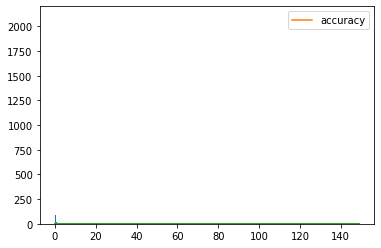

In [16]:

all4 = all3.sample(frac=1).reset_index(drop=True)

train = all4.iloc[:2500]
test = all4.iloc[2500:]


exclude_columns = ['next_game', 'team_x', 'team_opp', 'date', 'won', 'date_next', 'team_opp_next_x', 'team_opp_next_y', 'team_y']

x_train = train[train.columns.difference(exclude_columns)]#.to_numpy()
x_test = test[test.columns.difference(exclude_columns)]#.to_numpy()


y_train = train['next_game']#.to_numpy()
y_test = test['next_game']#.to_numpy()

model = Sequential()
model.add(Dense(60, input_dim=614, activation = 'relu')) # play around
# model.add(Dense(10, activation='relu'))
model.add(Dropout(0.05)) # play around # try to avoid overfitting
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

print(model.summary())
history = model.fit(x_train, y_train, epochs=150, batch_size=100, validation_data=[x_test, y_test])

plt.hist(model.predict(x_test),100)

# Finetune
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), # play around
              loss='binary_crossentropy', 
              metrics=['accuracy'])
history2 = model.fit(x_train, y_train, epochs=50, batch_size=100, validation_data=[x_test, y_test])


Training Method 2: Use past seasons to predict current season

 
2018.0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 60)                36900     
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 61        
                                                                 
Total params: 36,961
Trainable params: 36,961
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/350
25/25 [==============================] - 1s 25ms/step - loss: 44.8787 - accuracy: 0.4950 - val_loss: 11.1862 - val_accuracy: 0.5012
Epoch 2/350
25/25 [==============================] - 0s 6ms/step - loss: 22.9637 - accuracy: 0.4963 - val_loss: 9.8398 - val_accuracy: 0.5148
Epoch 3/350
25

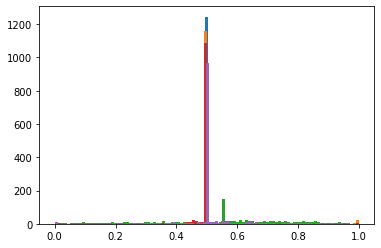

In [17]:
# def backtest(data, model, predictors, start=2, step=1):
def backtestNN(data, start=2, step=1):

  all_predictions=[]
  all_predictions2=[] # list of dataframes, where each df is predictions for a single season
  seasons = sorted(data["season"].unique())

  for i in range(start, len(seasons), step):
    season = seasons[i]
    print(" ")
    print(season)

    # train = data[data["season"] < season] # all data that comes before current season
    train = data[data["season"].isin([season-1,season-2])] # all data that comes before current season
    test = data[data["season"] == season] # current season

    exclude_columns = ['next_game', 'team_x', 'team_opp', 'date', 'won', 'date_next', 'team_opp_next_x', 'team_opp_next_y', 'team_y']
    
    x_train = train[train.columns.difference(exclude_columns)]#.to_numpy()
    x_test = test[test.columns.difference(exclude_columns)]#.to_numpy()
    

    y_train = train['next_game']#.to_numpy()
    y_test = test['next_game']#.to_numpy()

    model = Sequential()

    if season == 2018:
      # continue
      # print("A")

      # Model
      model.add(Dense(60, input_dim=614, activation = 'relu')) # play around
      model.add(Dropout(0.05)) # play around # try to avoid overfitting
      model.add(Dense(1, activation='sigmoid'))

      model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
      
      print(model.summary())
      history = model.fit(x_train, y_train, epochs=350, batch_size=100, validation_data=[x_test, y_test])
      
      # plt.hist(model.predict(x_test),100)

      # Finetune
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), # play around
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
      history2 = model.fit(x_train, y_train, epochs=50, batch_size=100, validation_data=[x_test, y_test])
      
    

    elif season == 2019:
      # continue
      # print("B")


      # Model
      model.add(Dense(60, input_dim=614, activation = 'relu')) # play around
      model.add(Dropout(0.05)) # play around # try to avoid overfitting
      model.add(Dense(1, activation='sigmoid'))

      model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
      
      print(model.summary())
      history = model.fit(x_train, y_train, epochs=350, batch_size=100, validation_data=[x_test, y_test])
      
      # plt.hist(model.predict(x_test),100)

      # Finetune
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), # play around
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
      history2 = model.fit(x_train, y_train, epochs=50, batch_size=100, validation_data=[x_test, y_test])


    elif season == 2020:
      # continue
      # print("C")

      # Model
      model.add(Dense(60, input_dim=614, activation = 'relu')) # play around
      model.add(Dropout(0.1)) # play around # try to avoid overfitting
      # model.add(Dense(10, input_dim=614, activation = 'relu')) # play around
      model.add(Dense(1, activation='sigmoid'))

      model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
      
      print(model.summary())
      history = model.fit(x_train, y_train, epochs=200, batch_size=100, validation_data=[x_test, y_test])
      
      # plt.hist(model.predict(x_test),100)

      # Finetune
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), # play around
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
      history2 = model.fit(x_train, y_train, epochs=20, batch_size=100, validation_data=[x_test, y_test])

    elif season == 2021:
      # print("D")
      
      # Model
      model.add(Dense(60, input_dim=614, activation = 'relu')) # play around
      model.add(Dropout(0.5)) # play around # try to avoid overfitting
      # model.add(Dense(60, activation = 'relu'))
      # model.add(Dropout(0.1)) # play around # try to avoid overfitting
      model.add(Dense(1, activation='sigmoid'))

      model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
      
      print(model.summary())
      history = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=[x_test, y_test])
      
      # plt.hist(model.predict(x_test),100)

      # Finetune
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), # play around
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
      history2 = model.fit(x_train, y_train, epochs=20, batch_size=100, validation_data=[x_test, y_test])
      # history2=5

    elif season == 2022:
      print("E")
      
      # Model
      model.add(Dense(60, input_dim=614, activation = 'relu')) # play around
      model.add(Dropout(0.1)) # play around # try to avoid overfitting
      model.add(Dense(1, activation='sigmoid'))

      model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
      
      print(model.summary())
      history = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=[x_test, y_test])
      
      # plt.hist(model.predict(x_test),100)

      # Finetune
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), # play around
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
      history2 = model.fit(x_train, y_train, epochs=20, batch_size=100, validation_data=[x_test, y_test])


    print("______ _______")
    

    


    all_predictions.append(history)
    all_predictions2.append(history)


  return [all_predictions,all_predictions2]



predictions,predictions2 = backtestNN(all3, start=2, step=1)
#2019 is overfitting

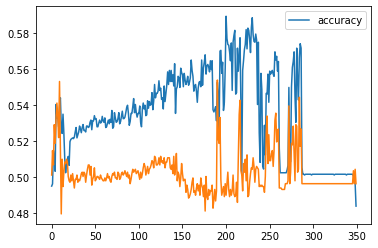

In [18]:
# plt1 = plt.plot(predictions[0].history['accuracy'], label='accuracy')
# plt1 = plt.plot(predictions[0].history['val_accuracy'])
# plt1 = plt.legend()
# plt1


# plt2 = plt.plot(predictions2[1].history['accuracy'], label='accuracy')
# plt2 = plt.plot(predictions2[1].history['val_accuracy'])
# plt2 = plt.legend()
# plt2


# plt3 = plt.plot(predictions[2].history['accuracy'], label='accuracy')
# plt3 = plt.plot(predictions[2].history['val_accuracy'])
# plt3 = plt.legend()
# plt3

# plt4 = plt.plot(predictions[3].history['accuracy'], label='accuracy')
# plt4 = plt.plot(predictions[3].history['val_accuracy'])
# plt4 = plt.legend()
# plt4

# plt5 = plt.plot(predictions[4].history['accuracy'], label='accuracy')
# plt5 = plt.plot(predictions[4].history['val_accuracy'])
# plt5 = plt.legend()
# plt5